Using device: cpu
Found 10 styles
Processing 50 images for style: 3d rendered
Processing 50 images for style: artistic
Processing 50 images for style: cartoon
Processing 50 images for style: digital art
Processing 50 images for style: geometric
Processing 50 images for style: minimalistic
Processing 50 images for style: realistic
Processing 50 images for style: retro
Processing 50 images for style: storybook
Processing 50 images for style: technical


C:\Users\SouayedBelkiss\AppData\Local\Temp\ipykernel_13008\3077465974.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=style_means.index, y=style_means.values, palette="viridis")



=== STYLE EVALUATION REPORT ===

Style Rankings (by CLIP Score):
1. geometric: 0.2182
2. 3d rendered: 0.2110
3. technical: 0.1976
4. retro: 0.1910
5. minimalistic: 0.1901
6. storybook: 0.1880
7. artistic: 0.1849
8. cartoon: 0.1848
9. digital art: 0.1837
10. realistic: 0.1707

Results saved to ../clip_analysis


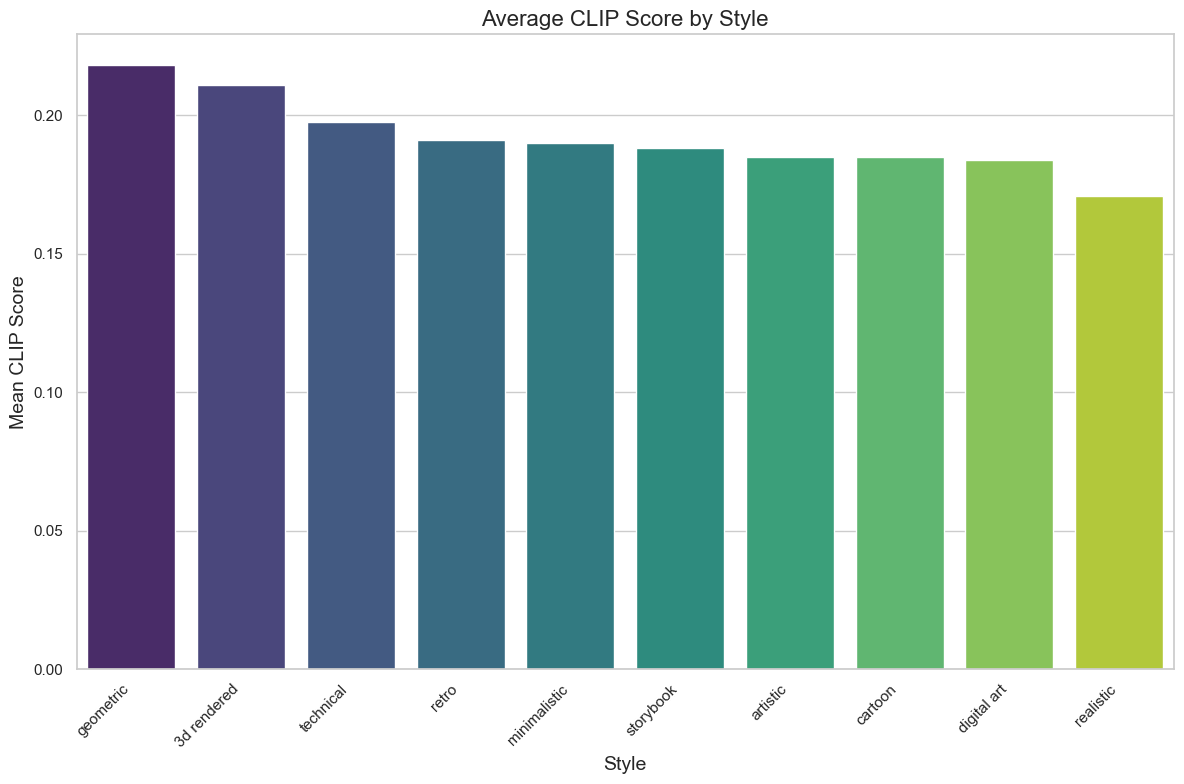

In [ ]:
import torch
import clip
from PIL import Image
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Set paths
base_path = '../images'
results_path = '../clip_analysis'
os.makedirs(results_path, exist_ok=True)

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
model, preprocess = clip.load('ViT-L/14', device=device)

def get_clip_score(image_path, style_name):
    """Calculate CLIP score using just the style name"""
    try:
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        image_input = preprocess(image).unsqueeze(0).to(device)
        
        # Use style name as text
        text = f"An image in {style_name} style"
        text_input = clip.tokenize([text]).to(device)
        
        # Calculate similarity
        with torch.no_grad():
            image_features = model.encode_image(image_input)
            text_features = model.encode_text(text_input)
            
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            
            similarity = torch.matmul(image_features, text_features.T).item()
            return similarity
    except Exception:
        return 0.0

# Process styles directly without the detailed prompts
results = []
style_path = os.path.join(base_path, 'by_style')

styles = [d for d in os.listdir(style_path) if os.path.isdir(os.path.join(style_path, d))]
print(f"Found {len(styles)} styles")

for style in styles:
    style_dir = os.path.join(style_path, style)
    image_files = [f for f in os.listdir(style_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Process only a sample of images per style (for speed)
    sample_size = min(50, len(image_files))
    sample_files = image_files[:sample_size]
    
    print(f"Processing {len(sample_files)} images for style: {style}")
    
    for img_file in sample_files:
        image_path = os.path.join(style_dir, img_file)
        clip_score = get_clip_score(image_path, style)
        
        results.append({
            'style': style,
            'clip_score': clip_score,
            'filename': img_file
        })

# Analyze results
df = pd.DataFrame(results)
df.to_csv(os.path.join(reSsults_path, 'clip_scores_simple.csv'), index=False)

# Create visualizations
plt.figure(figsize=(12, 8))
style_means = df.groupby('style')['clip_score'].mean().sort_values(ascending=False)

sns.barplot(x=style_means.index, y=style_means.values, palette="viridis")
plt.title('Average CLIP Score by Style', fontsize=16)
plt.xlabel('Style', fontsize=14)
plt.ylabel('Mean CLIP Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(results_path, 'style_performance.png'), dpi=300)

# Print simple report
print("\n=== STYLE EVALUATION REPORT ===\n")
print("Style Rankings (by CLIP Score):")
for i, (style, score) in enumerate(style_means.items(), 1):
    print(f"{i}. {style}: {score:.4f}")

print(f"\nResults saved to {results_path}")